In [1]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections
import pandas as pd
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from pygsp import utils
from pygsp import graphs, filters
from sklearn.linear_model import LinearRegression

In [2]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','CCS':'C','AC5':'L'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

amino_bulkiness = {'A':11.5, 'D':11.68,'C':13.46,'E':13.57,'F':19.8,'G':3.4,'H':13.67,'I':21.4,'K':15.71,'L':21.4,
                   'M':16.25,'N':12.82,'P':17.43,'Q':14.45,'R':14.28,'S':9.47,'T':15.77,'V':21.57,'W':21.61,'Y':18.03}

amino_polarity = {'A':0, 'D':49.7,'C':1.48,'E':49.9,'F':0.35,'G':0,'H':51.6,'I':0.1,'K':49.5,'L':0.13,
                   'M':1.43,'N':3.38,'P':1.58,'Q':3.53,'R':52,'S':1.67,'T':1.66,'V':0.13,'W':2.1,'Y':1.61}

amino_turn_tendency = {'A':0.66, 'D':1.46,'C':1.19,'E':0.74,'F':0.6,'G':1.56,'H':0.95,'I':0.47,'K':1.01,'L':0.59,
                   'M':0.6,'N':1.56,'P':1.52,'Q':0.98,'R':0.95,'S':1.43,'T':0.96,'V':0.5,'W':0.96,'Y':1.14}

amino_coil_tendency = {'A':0.71, 'D':1.21,'C':1.19,'E':0.84,'F':0.71,'G':1.52,'H':1.07,'I':0.66,'K':0.99,'L':0.69,
                   'M':0.59,'N':1.37,'P':1.61,'Q':0.87,'R':1.07,'S':1.34,'T':1.08,'V':0.63,'W':0.76,'Y':1.07}

amino_flexibility = {'A':0, 'D':2,'C':1,'E':3,'F':2,'G':0,'H':2,'I':2,'K':4,'L':2,
                   'M':3,'N':2,'P':0,'Q':3,'R':5,'S':1,'T':1,'V':1,'W':2,'Y':2}

amino_partial_specific_volume = {'A':60.46, 'D':73.83,'C':67.7,'E':85.88,'F':121.48,'G':43.25,'H':98.79,
                                 'I':107.72,'K':108.5,
                                 'L':107.75,'M':105.35,'N':78.01,'P':82.83,'Q':93.9,
                                 'R':127.34,'S':60.62,'T':76.83,'V':90.78,'W':143.91,'Y':123.6}

amino_compressibility = {'A':-25.5, 'D':-33.12,'C':-32.82,'E':-36.17,'F':-34.54,'G':-27,'H':-31.84,
                        'I':-31.78,'K':-32.4,
                        'L':-31.78,'M':-31.18,'N':-30.9,'P':-23.25,'Q':-32.6,
                        'R':-26.62,'S':-29.88,'T':-31.23,'V':-30.62,'W':-30.24,'Y':-35.01}

amino_refractive_index = {'A':14.34, 'D':12,'C':35.77,'E':17.26,'F':29.4,'G':0,'H':21.81,
                        'I':19.06,'K':21.29,
                        'L':18.78,'M':21.64,'N':13.28,'P':10.93,'Q':17.56,
                        'R':26.66,'S':6.35,'T':11.01,'V':13.92,'W':42.53,'Y':31.55}




In [4]:
amino_ = {'A':, 'D':,'C':,'E':,'F':,'G':,'H':,
                        'I':,'K':,
                        'L':,'M':,'N':,'P':,'Q':,
                        'R':,'S':,'T':,'V':,'W':,'Y':}

SyntaxError: invalid syntax (<ipython-input-4-7e9c1f2f4d8c>, line 1)

In [5]:
def crawl_pdb(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
#         print(np.unique(labels))
        info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
#     print(distance_matrix.shape)
    G = graphs.Graph(distance_matrix)
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, pdb,signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'bulkiness':
        s = np.asarray([amino_bulkiness[aa] for aa in seq])
    elif signal == 'polarity':
        s = np.asarray([amino_polarity[aa] for aa in seq])
    elif signal == 'turn_tendency':
        s = np.asarray([amino_turn_tendency[aa] for aa in seq])
    elif signal == 'coil_tendency':
        s = np.asarray([amino_coil_tendency[aa] for aa in seq])
    elif signal == 'flexibility':
        s = np.asarray([amino_flexibility[aa] for aa in seq])
    elif signal == 'partial_specific_volume':
        s = np.asarray([amino_partial_specific_volume[aa] for aa in seq])
    elif signal == 'compressibility':
        s = np.asarray([amino_compressibility[aa] for aa in seq])
    elif signal == 'refractive_index':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'conservation_score':
        #https://compbio.cs.princeton.edu/conservation/
        filename = pdb.split('.')[0]
#         cmd = ['python3 ./pdb2fasta-master/pdb2fasta.py '+pdb_path+''+pdb+' > ./pdb2fasta-master/'+filename+'.fasta']
#         print(cmd)
#         process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open('./pdb2fasta-master/'+filename+'.fasta', 'w') as the_file:
            the_file.write('>'+filename+':A\n'+seq+"-")
        process = 0
        if process ==0:
            s = []
            cmd = ['python2 ./pdb2fasta-master/conservation_code/score_conservation.py -alignfile ./pdb2fasta-master/'+filename+'.fasta > ./pdb2fasta-master/'+filename+'.csv']
#             print(cmd)
            process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if process ==0:
                with open('./pdb2fasta-master/'+filename+'.csv') as f:
                    for i in range(5):
                        next(f)
                    for line in f:
#                         print(line.split("\t")[1])
                        s.append(float(line.split("\t")[1]))
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_filtered_signal(G, signal, cutoff,type_spatial):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                p = np.percentile(signal_filtered_hat[:,j], cutoff) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
        signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        return signal_filtered_hat

In [6]:
signals_and_cutoffs = {'molecular_weight': 0.42, 
                       'hydrophobicity': 0.42, 
                       'node_degree': 0.42, 
                       'node_weighted_degree': 0.42, 
                       'residue_count': 0.42, 
                       'clustering_coeff': 0.42,
                      'conservation_score': 0.42}

signals_wavelet = []
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','conservation_score','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility']
for i in signals:
    for j in range(1,5):
        signals_wavelet.append(i+"_"+str(j))

# TransmembraneGlobular_regression

In [480]:
# pdbinfo_dict_trans = crawl_pdb('../Protein-GSP-master/data/transmembrane/')
# pdbinfo_dict_glob = crawl_pdb('../Protein-GSP-master/data/globular/')

# G_glob = {}
# G_trans = {}

# for pdb in pdbinfo_dict_glob.keys():
#     try:
#         G_glob[pdb] = get_graph(pdbinfo_dict_glob[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
#     except:
#         continue
        
# for pdb in pdbinfo_dict_trans.keys():
#     try:
#         G_trans[pdb] = get_graph(pdbinfo_dict_trans[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
#     except:
#         continue 
    
lfc_cutoff = 0.59
model = 'weighted-rig'

gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in G_glob.keys():
    row = []
    c = -1
    G = G_glob[pdb]
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_glob[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb] = row


import random   
for pdb in G_trans.keys():
    row = []
    c = 1
    G = G_trans[pdb]
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_trans[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb] = row

X_all = gsp_features[gsp_features.columns.difference(['class'])]
y_all = gsp_features['class']


In [486]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

# nm = NearMiss(version=1)
# X, y = nm.fit_resample(X_all, y_all) 

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.7512350991264984


In [481]:
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot
# # define the model
# model = RandomForestRegressor()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()

# model.score(X,y)

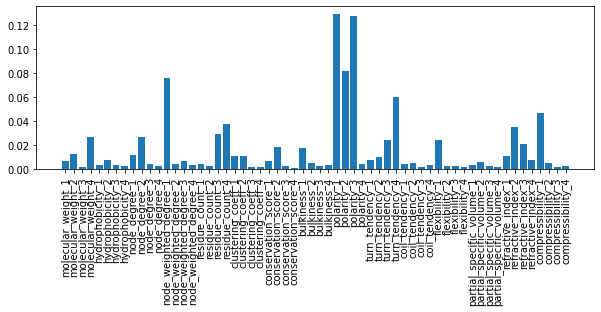

Accuracy: 0.73 (+/- 0.02)


In [487]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# alpha-beta

In [488]:
def crawl_pdb_alphabeta(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path + '' + pdb + '/' + pdb.split('_')[1].upper()+'.pdb' ) # + '/' + pdb + '.pdb'
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        assert residue.get_resname() not in ['HOH', ' CA']
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())

                    except :
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
        info['sequence'] = ''.join([amino_lookup[s] for s in labels])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


In [489]:
path = '../Protein-GSP-master/data/SDTSF_RIG_LIN/'
pdbinfo_dict = crawl_pdb_alphabeta(path)

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CH3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstruc

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=NH2) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=HE) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1HH1) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=2HH1) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1HH2) with given element '4'
  warnings.warn(ms

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

In [490]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#         print (pdb, end=', ')
    row = []
    if pdb.startswith('A_'): c = 1
    elif pdb.startswith('B_'): c = -1
    else: c = 0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

1.0


In [445]:
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot
# # define the model
# model = RandomForestRegressor()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()
model.score(X,y)

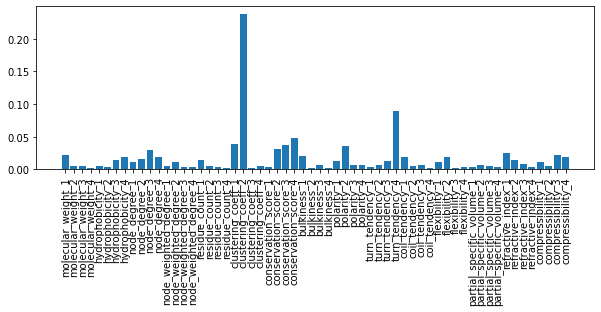

Accuracy: 0.78
0.02432220195007022


In [491]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f" % (scores.mean()))
print(scores.std())

# Protein folding rate using gsp features

In [7]:
import pickle as pk 
def crawl_pdb_allproteins(path1,path2):
    '''This funciton reads pdb files and stores their distance matrix and sequence''' 
    count=0
    parser = PDBParser()
    pdb_files_1 = sorted(os.listdir(path1))
    pdb_files_2 = sorted(os.listdir(path2))
    pdbinfo_dict = dict()
    for pdb in pdb_files_1:
#         print (pdb)
        info = dict()
        info[id] = pdb         
        info['distance_matrix'] = pd.read_csv(path1 + pdb + '/distance_matrix.csv', header=None).values
        info['sequence'] = pk.load(open(path1 + pdb + '/sequence.p', 'rb'))
        str1 = ''.join(info['sequence'])
        info['sequence']= str1
        pdbinfo_dict[pdb.upper()] = info
    for pdb in pdb_files_2:
#         print (pdb)
        if pdb in pdbinfo_dict.keys(): 
            count=count+1
            pass
        else:
            info = dict()
            info[id] = pdb   
            structure = parser.get_structure('pdb_file', path2 +pdb+"/" +"pdb" +pdb.lower()+".ent" )
            coordinates = []
            labels = list()
            for model in structure:
                for chain in model:
                    for residue in chain:
                        try:
                            if residue.get_resname() in amino_lookup:
                                coordinates.append(residue['CA'].get_coord())
                                labels.append(residue.get_resname())
                        except KeyError:
                            pass
                    break  ## working on chain id A only
                break      ## Working on model id 0 only
            coords = np.asmatrix(coordinates)
            distance_matrix = distance.squareform(distance.pdist(coords))
            info['coords'] = coords
            info['distance_matrix'] = distance_matrix
            info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
            pdbinfo_dict[pdb.upper()] = info
#     print(count)
    return pdbinfo_dict

In [8]:
path1 = '../Protein-GSP-master/data/regression_model/new_pdb/'
path2 = '../Protein-GSP-master/data/regression_model/test_pdb/'
pdbinfo_dict = crawl_pdb_allproteins(path1,path2)

# df = pd.read_csv('../Protein-GSP-master/data/regression_model/data_all_proteins.csv', index_col=0)
# lnkfs = df['Ln.K_f.']

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2248.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2249.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2250.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2278.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4219.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1470.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1535.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5602.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5832.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4562.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

In [9]:
df= pd.read_csv('../Protein-GSP-master/data/regression_model/final_lnkf.csv', index_col=0,sep=",")
lnkfs = df['Ln.K_f.']

In [10]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#     print(pdb)
    #         print (pdb, end=', ')
    row = []
    c = lnkfs[pdb.upper()]
    if isinstance(c, pd.Series):
#         print(c)
        c = c.iloc[0]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
#         print(row)
        gsp_features.loc[pdb] = row

# gsp_features.dropna()
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.721530760288776


In [11]:
gsp_features.shape

(163, 61)

In [688]:
gsp_features.to_csv("../Protein-GSP-master/data/regression_model/gsp_features.txt")

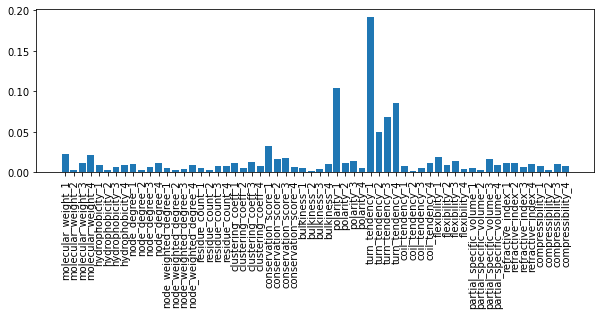

Accuracy: 0.51 (+/- 0.02)


In [12]:
# Cutoff=10
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [691]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X, y)
reg.score(X, y)

0.4281873923812687

# AROMATICITY PREDICTION

In [502]:
import pickle as pk 
def crawl_pdb_allproteins(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
#         print (pdb)
        info = dict()
        info[id] = pdb
        
        info['distance_matrix'] = pd.read_csv(path + pdb + '/distance_matrix.csv', header=None).values
        info['sequence'] = pk.load(open(path + pdb + '/sequence.p', 'rb'))
        str1 = ''.join(info['sequence'])
        info['sequence']= str1
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict

In [503]:
path = '../Protein-GSP-master/data/regression_model/new_pdb/'
pdbinfo_dict = crawl_pdb_allproteins(path)

In [14]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
def aromaticity(seq):
    X =  ProteinAnalysis(seq)
    aroma = X.aromaticity()
    return aroma

def isoelectric_point(seq):
    X =  ProteinAnalysis(seq)
    isoelectric_point = X.isoelectric_point()
    return isoelectric_point

def instability_index(seq):
    X =  ProteinAnalysis(seq)
    instability_index = X.instability_index()
    return instability_index

def gravy(seq):
    X =  ProteinAnalysis(seq)
    gravy = X.gravy()
    return gravy

def charge(seq):
    X =  ProteinAnalysis(seq)
    charge_at_pH = X.charge_at_pH()
    return charge_at_pH

def molar_extinction_coefficient(seq):
    X =  ProteinAnalysis(seq)
    molar_extinction_coefficient = X.molar_extinction_coefficient()
    return molar_extinction_coefficient

In [15]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        c=aromaticity(pdbinfo_dict[pdb]['sequence'])
        row.append(c)
        gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.8575443719023652


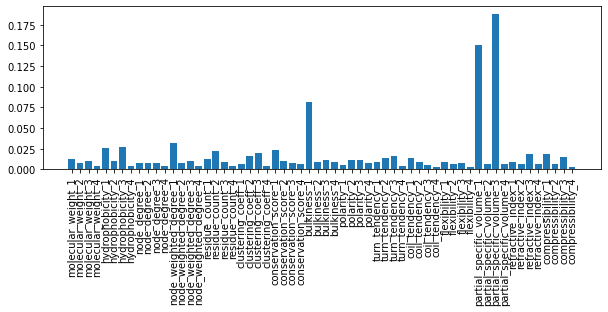

Accuracy: 0.69 (+/- 0.01)


In [16]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [17]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X, y)
reg.score(X_test, y_test)

0.7257137161907283

# isoelectric point

In [19]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        c= isoelectric_point(pdbinfo_dict[pdb]['sequence'])
        row.append(c)
        gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.7512939616510479


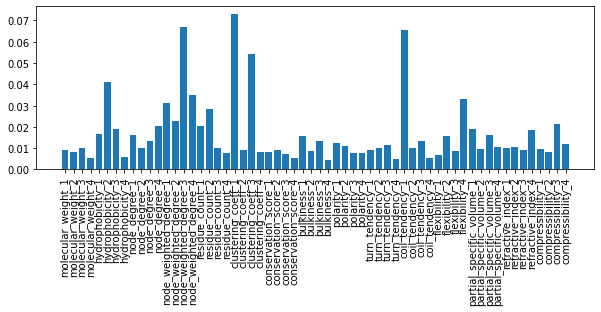

Accuracy: 0.39 (+/- 0.03)


In [20]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators = 1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [21]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X, y)
reg.score(X, y)

0.6335914186811971

# instability index

In [22]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    c= instability_index(pdbinfo_dict[pdb]['sequence'])
    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

ZeroDivisionError: division by zero

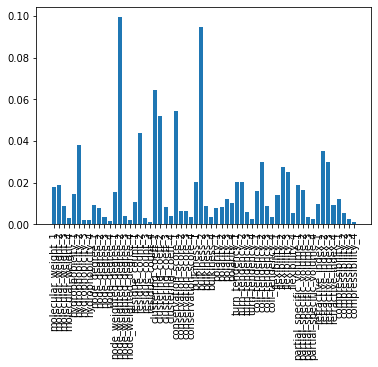

Accuracy: 0.61 (+/- 0.02)


In [521]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators = 1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [522]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X, y)
reg.score(X, y)

0.5734752822584477

# correlation protein folding rate

In [359]:
import pickle

def get_filtered_signal_inverse(G, signal,cutoff):
    N_f=4
    scales = utils.compute_log_scales(1, len(signal), N_f-1)
    mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
    signal_filtered_hat = mex.filter(signal)
    signal_filtered_hat = np.abs(signal_filtered_hat)
    for j in range(signal_filtered_hat.shape[1]):
        p = np.percentile(signal_filtered_hat[:,j], cutoff) 
        signal_filtered_hat[np.where(signal_filtered_hat[:,j]<cutoff),j] = 0
    inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
    value = np.mean(np.abs(inv_fil))
    return value

In [540]:
folders = sorted(os.listdir('../Protein-GSP-master/data/regression_model/new_pdb/'))

distance_cutoff = 7.3
G_dict = dict()
NX_dict = dict()

lfc_cutoffs = np.arange(10,80,10)
points = np.zeros_like(lfc_cutoffs)

for index, folder in enumerate(folders):
#     print(folder)
    n = np.asmatrix(np.loadtxt('../Protein-GSP-master/data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
    n[n >= distance_cutoff] = 0

    # taking |j-i| as weights
    for i in range(np.shape(n)[0]):
        for j in range(np.shape(n)[1]):
            if n[i,j] > 0:
                n[i,j] = abs(j-i)
    
    G = graphs.Graph(n)
    G.compute_fourier_basis()
    
    G_dict[folder] = G
    NX_dict[folder] = nx.Graph(n)
    
for p, lfc_cutoff in enumerate(lfc_cutoffs):   
    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        print(folder)
        G = G_dict[folder]
        sequence = pickle.load(open('../Protein-GSP-master/data/regression_model/new_pdb/' + folder + '/sequence.p','rb'))
        str1 = ''.join(sequence)
        sequence = str1
        signal = get_signal(G, sequence,folder,signal=signal_name)
        NX = NX_dict[folder]
        signal = np.array(signal)
        value = get_filtered_signal_inverse(G, signal,p)
        lfc[index] = value
        lnkf[index] = nx.average_clustering(NX)
        print(lnkf[index])
    points[p] = np.corrcoef(lfc, lnkf)[0,1]
    #print(np.corrcoef(lfc, lnkf)[0,1])
    
    #print(np.max(points))
    #print(lfc_cutoffs[np.argmax(points)])

1aey
-0.5216840686427859
1aps
-0.5969308761811631
1aye
-0.6174840510145888
1bdd
-0.4992011307228968
1brs
-0.5881290663571502
1c8c
-0.4875282255203563
1c9o
-0.565821726526094
1cis
-0.5680955633212474
1coa
-0.5640016361375753
1csp
-0.5589777201967187
1div
-0.5178520114713593
1ebd
-0.6186875131717914
1enh
-0.4521405066046404
1fkb
-0.5654251888218748
1g6p
-0.5434362553947681
1hdn
-0.5795482604909699
1hrc
-0.5700150841287072
1hz6
-0.515770014914869
1imq
-0.5445524345205653
1lmb
-0.4671235152656964
1lop
-0.6136383530570244
1mjc
-0.5673829440403159
1nyf
-0.5481041529257931
1pba
-0.541931087894635
1pca
-0.6189532765286664
1pgb
-0.48633708010972343
1pin
-0.6004577559614106
1pks
-0.570258860621319
1pnj
-0.5689749880439726
1poh
-0.585014346319509
1ris
-0.5335937606178325
1shf
-0.5516649491387834
1shg
-0.5463731843735987
1srl
-0.5801361844212983
1ten
-0.5973977454240607
1tit
-0.6134521545844699
1ubq
-0.5075134046704048
1urn
-0.5499209840259136
1vii
-0.42349138364879957
1vik
-0.5600884770018159
1wi

-0.541931087894635
1pca
-0.6189532765286664
1pgb
-0.48633708010972343
1pin
-0.6004577559614106
1pks
-0.570258860621319
1pnj
-0.5689749880439726
1poh
-0.585014346319509
1ris
-0.5335937606178325
1shf
-0.5516649491387834
1shg
-0.5463731843735987
1srl
-0.5801361844212983
1ten
-0.5973977454240607
1tit
-0.6134521545844699
1ubq
-0.5075134046704048
1urn
-0.5499209840259136
1vii
-0.42349138364879957
1vik
-0.5600884770018159
1wit
-0.6000708892208202
1ycc
-0.5747082260758892
256b
-0.5428950780376021
2abd
-0.5441228325292135
2acy
-0.5767351932140028
2ait
-0.5614595822720903
2ci2
-0.5659962998069298
2hqi
-0.5878910104502667
2pdd
-0.4634064246731204
2ptl
-0.5314838586144134
2vik
-0.5567583069806542
3mef
-0.5437130456521081


In [ ]:
distance_cutoff = 7.3
n = distance_matrix
n[n >= distance_cutoff] = 0
NX_graph = nx.Graph(n)
lnkf = nx.average_clustering(NX_graph) 

In [533]:
lnkf

array([0.59352018, 0.55049859, 0.53929958, 0.60701539, 0.55536537,
       0.61414254, 0.5678933 , 0.56660347, 0.56892786, 0.5717933 ,
       0.59579894, 0.53865095, 0.63626476, 0.56811854, 0.58074922,
       0.56015135, 0.56551691, 0.59704069, 0.58010136, 0.62680267,
       0.54137756, 0.56700739, 0.57804466, 0.581624  , 0.53850781,
       0.61487451, 0.54856047, 0.56537907, 0.56610541, 0.55709787,
       0.58649346, 0.57599002, 0.5790461 , 0.55982212, 0.55024164,
       0.54147837, 0.60199063, 0.5769954 , 0.65475682, 0.57115853,
       0.54877273, 0.56286908, 0.58106359, 0.58035062, 0.56172931,
       0.57037595, 0.56779417, 0.55549759, 0.62913688, 0.58773221,
       0.57306375, 0.58058849])

In [23]:
21499+3840+2157+45181+4994+27181+72662+183175+75490+42942+79248+9712+85261+3313+63958

720613